In [3]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
%pip install future

!pip uninstall h2o
%pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 MB 7.0 MB/s eta 0:00:00


**Abstract -**

The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be subscribed ('yes') or not ('no') subscribed.
AutoML algorithm is applied to train the model and get the best results.
Hyperparameter tuning is done to find the most important hypterparameters.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 
import scipy
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [5]:


data = pd.read_csv("https://github.com/Viral-28/Trialpart/raw/main/new_train.csv")

In [6]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


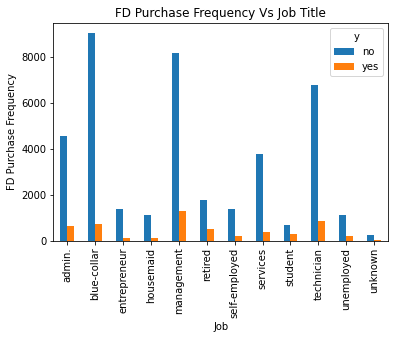

In [7]:
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('FD Purchase Frequency Vs Job Title')
plt.xlabel('Job')
plt.ylabel('FD Purchase Frequency')
plt.show()

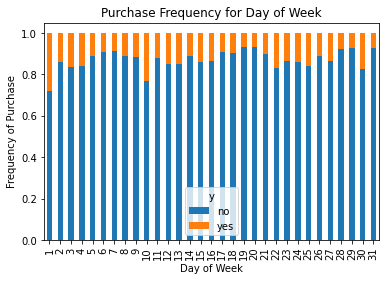

In [8]:
dow = pd.crosstab(data.day, data.y)
dow.div(dow.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.show()

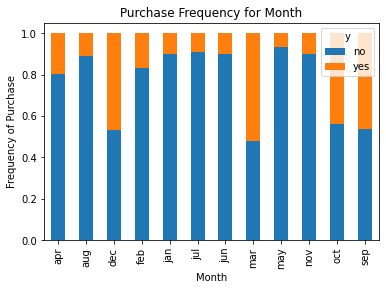

In [9]:
mon = pd.crosstab(data.month,data.y)
mon.div(mon.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.show()

In [10]:
df1 = data.dropna()
df1.drop(['campaign'], axis=1, inplace=True)
df1.drop(['marital'], axis=1, inplace=True)
df1.drop(['day'], axis=1, inplace=True)
df1.drop(['default'], axis=1, inplace=True)

df1 = df1.replace(to_replace = ['yes','no'],value = ['1','0'])

Job = pd.get_dummies(df1['job'])
Job.drop(['unknown'], axis=1, inplace=True)

Education = pd.get_dummies(df1['education'])
Education.drop(['unknown'], axis=1, inplace=True)

Contact = pd.get_dummies(df1['contact'], drop_first=True)

Month = pd.get_dummies(df1['month'], drop_first=True)

Poutcome = pd.get_dummies(df1['poutcome'], drop_first=True)

In [11]:
df1 = pd.concat([df1, Job, Education, Contact, Month, Poutcome], axis=1)
df1.drop(['job', 'education', 'contact', 'month', 'poutcome'], axis=1, inplace=True)
df1['housing'] = df1['housing'].apply(pd.to_numeric,errors="coerce")
df1 = df1.fillna(0)
df1['housing'] = df1['housing'].astype(int)
df1['loan'] = df1['loan'].apply(pd.to_numeric,errors="coerce")
df1 = df1.fillna(0)
df1['loan'] = df1['loan'].astype(int)
df1['y'] = pd.to_numeric(df1['y'])

In [12]:
df1.isna().sum()

age              0
balance          0
housing          0
loan             0
duration         0
pdays            0
previous         0
y                0
admin.           0
blue-collar      0
entrepreneur     0
housemaid        0
management       0
retired          0
self-employed    0
services         0
student          0
technician       0
unemployed       0
primary          0
secondary        0
tertiary         0
telephone        0
unknown          0
aug              0
dec              0
feb              0
jan              0
jul              0
jun              0
mar              0
may              0
nov              0
oct              0
sep              0
other            0
success          0
unknown          0
dtype: int64

In [13]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

In [14]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [15]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:25384..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3m33rdku
  JVM stdout: /tmp/tmp3m33rdku/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3m33rdku/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:25384
Connecting to H2O server at http://127.0.0.1:25384 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_f3sn2l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [16]:
# df1.rename(columns = {"unknown_poutcome": "unknown_contact"}, inplace = True)


cols = []
count = 1
for column in df1.columns:
    if column == 'unknown':
        cols.append(f'unknown_{count}')
        count+=1
        continue
    cols.append(column)
df1.columns = cols



In [17]:
df = h2o.H2OFrame(df1)
df.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


age,balance,housing,loan,duration,pdays,previous,y,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,primary,secondary,tertiary,telephone,unknown_1,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,other,success,unknown_2
58,2143,1,0,261,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
44,29,1,0,151,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
33,2,1,1,76,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
47,1506,1,0,92,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
33,1,0,0,198,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
35,231,1,0,139,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
28,447,1,1,217,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
42,2,1,0,380,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
58,121,1,0,50,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
43,593,1,0,55,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [18]:
# Create a 80/20 train/test splie
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

In [19]:
print(df_train.shape)
print(df_test.shape)

(36265, 38)
(8946, 38)


In [20]:
X=df.columns
print(X)

['age', 'balance', 'housing', 'loan', 'duration', 'pdays', 'previous', 'y', 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'primary', 'secondary', 'tertiary', 'telephone', 'unknown_1', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'other', 'success', 'unknown_2']


In [21]:
df.types

{'age': 'int',
 'balance': 'int',
 'housing': 'int',
 'loan': 'int',
 'duration': 'int',
 'pdays': 'int',
 'previous': 'int',
 'y': 'int',
 'admin.': 'int',
 'blue-collar': 'int',
 'entrepreneur': 'int',
 'housemaid': 'int',
 'management': 'int',
 'retired': 'int',
 'self-employed': 'int',
 'services': 'int',
 'student': 'int',
 'technician': 'int',
 'unemployed': 'int',
 'primary': 'int',
 'secondary': 'int',
 'tertiary': 'int',
 'telephone': 'int',
 'unknown_1': 'int',
 'aug': 'int',
 'dec': 'int',
 'feb': 'int',
 'jan': 'int',
 'jul': 'int',
 'jun': 'int',
 'mar': 'int',
 'may': 'int',
 'nov': 'int',
 'oct': 'int',
 'sep': 'int',
 'other': 'int',
 'success': 'int',
 'unknown_2': 'int'}

In [22]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [23]:
y = 'y'
X.remove('y')

In [24]:
aml.train(x=X,y=y,training_frame=df_train)  

AutoML progress: |
19:17:12.540: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
19:17:17.656: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
19:17:20.955: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█████
19:17:38.516: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
19:17:40.742: _response param, We ha

key,value
Stacking strategy,blending
Number of base models (used / total),6/12
# GBM base models (used / total),2/5
# XGBoost base models (used / total),2/3
# DRF base models (used / total),1/2
# GLM base models (used / total),0/1
# DeepLearning base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0


In [25]:
print(aml.leaderboard)

model_id                                                     rmse        mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20230228_191711     0.248157  0.0615817  0.130466  0.173285                 0.0615817
StackedEnsemble_AllModels_1_AutoML_1_20230228_191711     0.248192  0.0615992  0.130571  0.173303                 0.0615992
StackedEnsemble_AllModels_3_AutoML_1_20230228_191711     0.248201  0.0616038  0.13005   0.173254                 0.0616038
StackedEnsemble_BestOfFamily_3_AutoML_1_20230228_191711  0.248254  0.0616299  0.13075   0.173354                 0.0616299
StackedEnsemble_BestOfFamily_4_AutoML_1_20230228_191711  0.248696  0.0618495  0.131179  0.173759                 0.0618495
StackedEnsemble_BestOfFamily_2_AutoML_1_20230228_191711  0.248834  0.0619185  0.131698  0.173839                 0.0619185
GBM_1_AutoML_1_20230228_191711                           0.249418  0.0622093  0.135185  0.174393                 0.0622093
GBM_2_AutoML_1_2

In [26]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'StackedEnsemble_AllModels_2_AutoML_1_20230228_191711': 0,
 'StackedEnsemble_AllModels_1_AutoML_1_20230228_191711': 1,
 'StackedEnsemble_AllModels_3_AutoML_1_20230228_191711': 2,
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20230228_191711': 3,
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20230228_191711': 4,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20230228_191711': 5,
 'GBM_1_AutoML_1_20230228_191711': 6,
 'GLM_1_AutoML_1_20230228_191711': 37}

In [27]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

6


In [28]:
best_model.algo

'gbm'

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

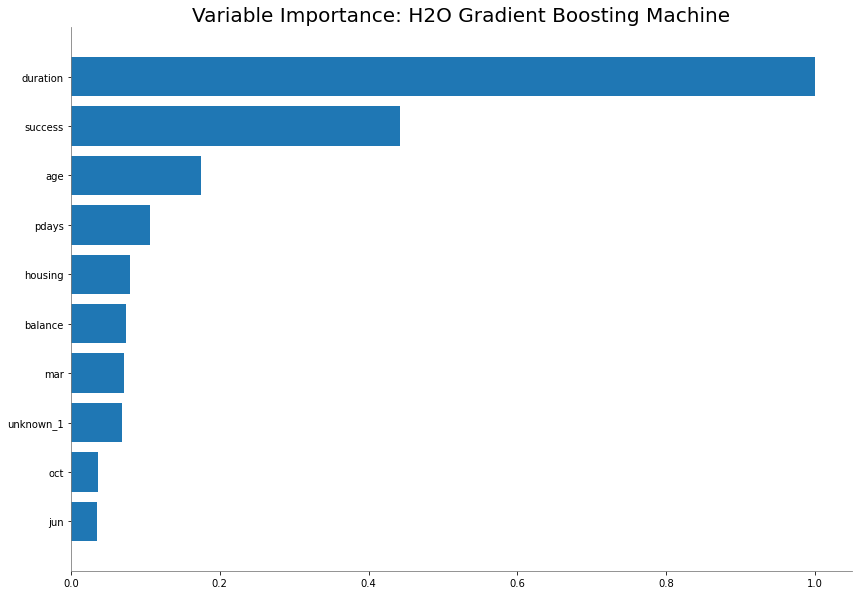

<Figure size 432x288 with 0 Axes>

In [30]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

**Write 4 top variables**

Duration, pdays, success and age

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-31-dd7790b8306f>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


37
glm


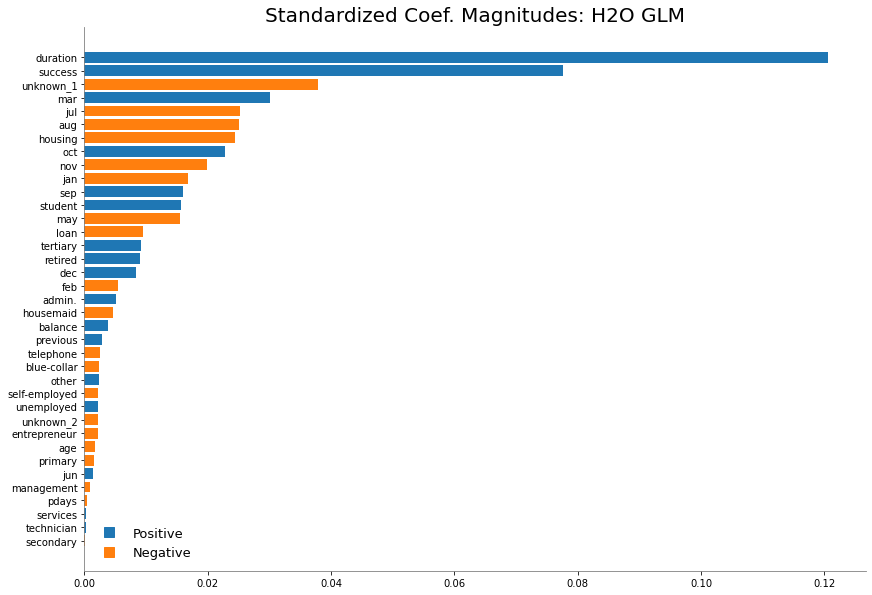

In [31]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [32]:
print(best_model.rmse(train = True))

0.2387699197672412


In [33]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [34]:
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.0642961591407154,
 'rmse': 0.25356687311381076,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [35]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [36]:
y_pred=h2o.as_list(predictions)
y_pred[0:5]

,predict
0,-0.000343
1,0.022583
2,-0.013810
3,0.018122
4,0.003242


In [37]:
y_test=h2o.as_list(df_test[y])
y_test.head()

,y
0,0
1,0
2,0
3,0
4,0


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model GBM_1_AutoML_1_20230228_191711 on column 'duration'.
duration    mean_response    stddev_response    std_error_mean_response
----------  ---------------  -----------------  -------------------------
0           0.0120055        0.0743875          0.000349847
258.842     0.106813         0.180822           0.000850412
517.684     0.242536         0.169136           0.000795452
776.526     0.415949         0.135709           0.000638241
1035.37     0.628628         0.127224           0.000598338
1294.21     0.616635         0.119449           0.000561773
1553.05     0.592208         0.117145           0.000550938
1811.89     0.574244         0.116179           0.000546393
2070.74     0.574244         0.116179           0.000546393
2329.58     0.574244         0.116179           0.000546393
2588.42     0.574244         0.116179           0.000546393
2847.26     0.574244         0.116179           0.000546393
3106.11     0.574244        

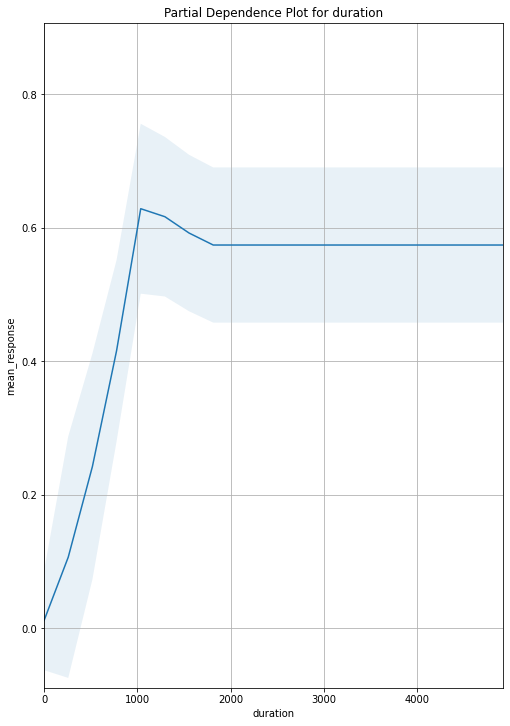

In [38]:
best_model.partial_plot(df, cols=['duration'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model GBM_1_AutoML_1_20230228_191711 on column 'age'.
age      mean_response    stddev_response    std_error_mean_response
-------  ---------------  -----------------  -------------------------
18       0.16472          0.219894           0.00103417
22.0526  0.16472          0.219894           0.00103417
26.1053  0.138787         0.204999           0.000964116
30.1579  0.124496         0.202517           0.000952445
34.2105  0.114304         0.19799            0.000931153
38.2632  0.10667          0.195005           0.000917115
42.3158  0.112146         0.197452           0.000928624
46.3684  0.116725         0.199409           0.000937826
50.4211  0.107232         0.193671           0.000910843
54.4737  0.108677         0.186772           0.000878393
58.5263  0.113082         0.186191           0.00087566
62.5789  0.321102         0.170689           0.000802754
66.6316  0.296654         0.184567           0.000868022
70.6842  0.274096    

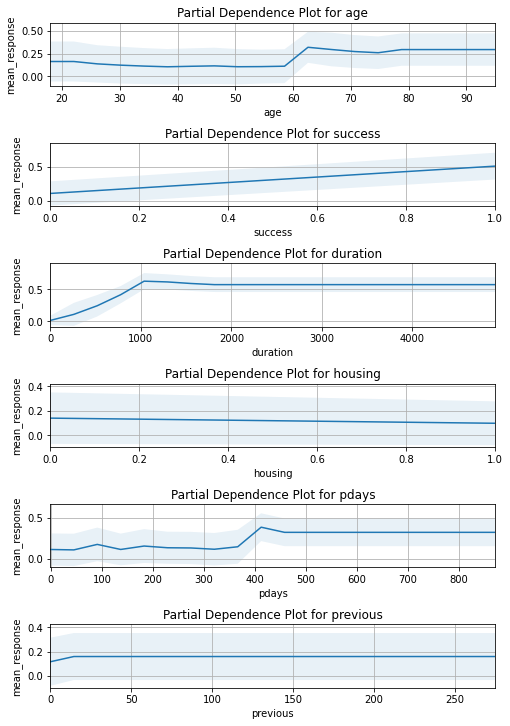

In [39]:
best_model.partial_plot(df, cols=['age', 'success', 'duration', 'housing', 'pdays', 'previous'])

**Is the relationship significant?**

Z_score == 0 it means all the predictors are on regression line it means the relationship is significant.

In [40]:
import scipy 
def diagnostic_plots(df1, variable):
    
    plt.figure(figsize=(20, 9))

    plt.subplot(1, 3, 1)
    sns.histplot(data = df1, x=variable, bins=30, kde=True)
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    scipy.stats.probplot(df1[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')
    
    plt.show()

In [41]:
num_columns=df1[['duration','pdays','success','age', 'previous', 'telephone', 'housing', 'mar', 'oct', 'unknown_1']].columns
num_columns

Index(['duration', 'pdays', 'success', 'age', 'previous', 'telephone',
       'housing', 'mar', 'oct', 'unknown_1'],
      dtype='object')

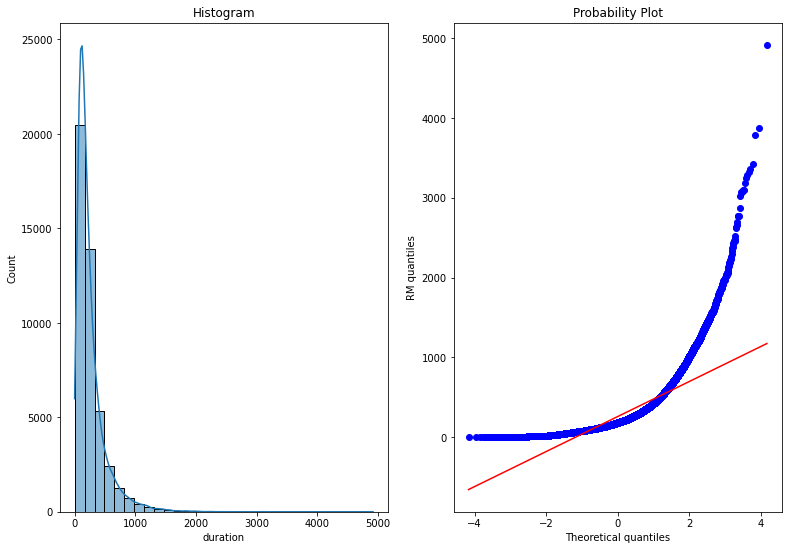

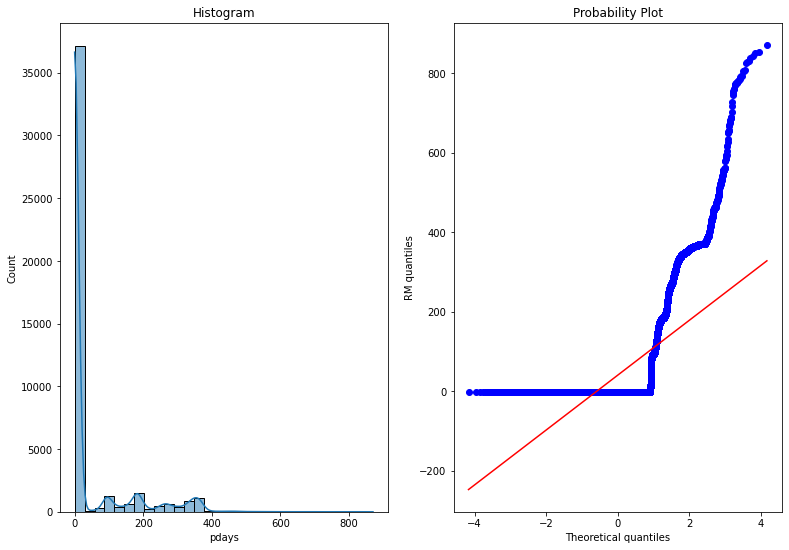

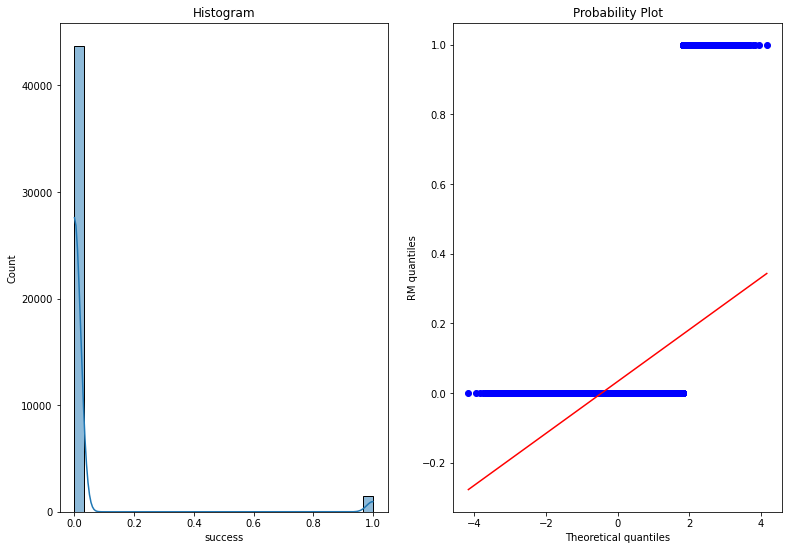

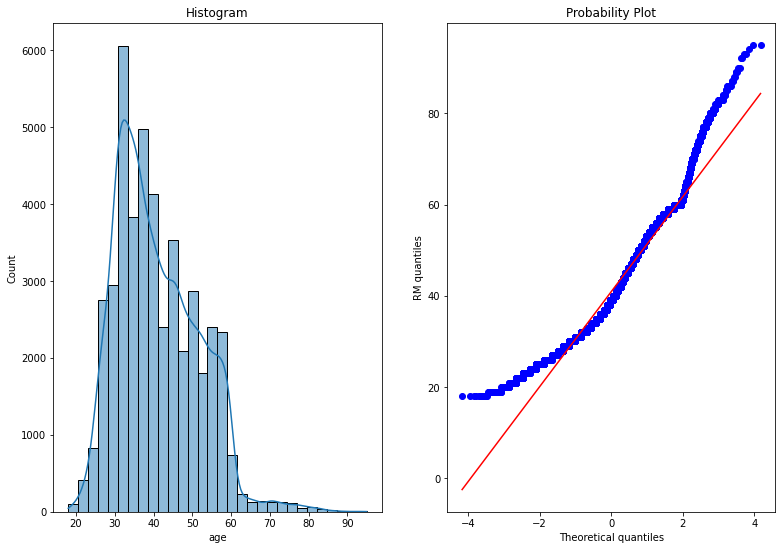

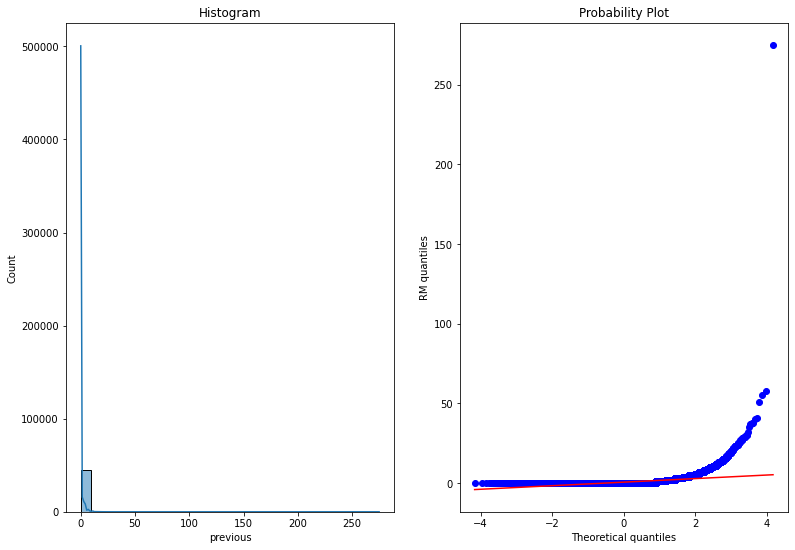

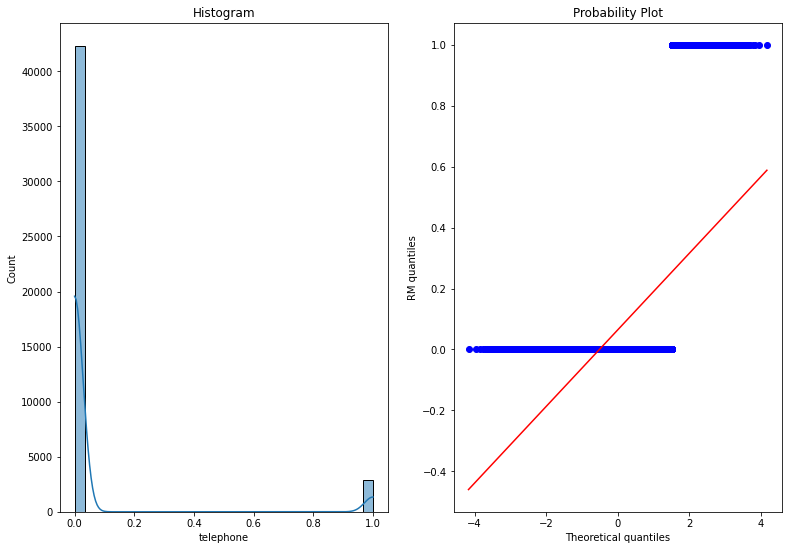

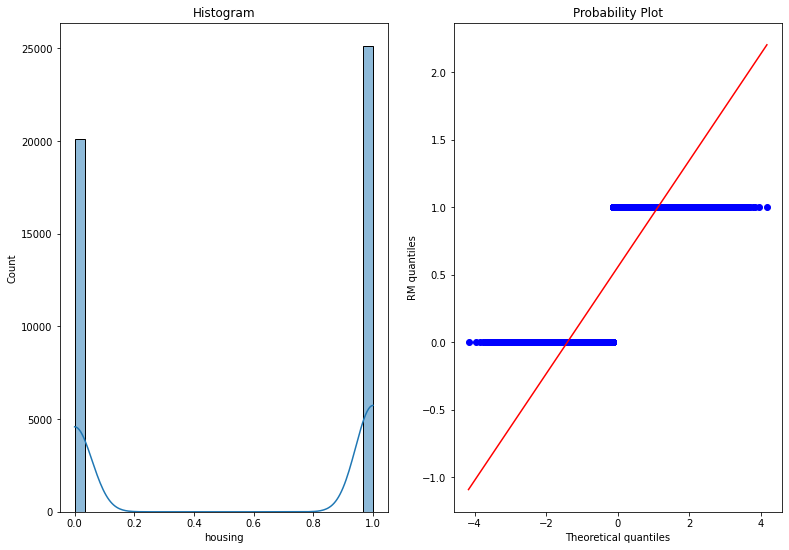

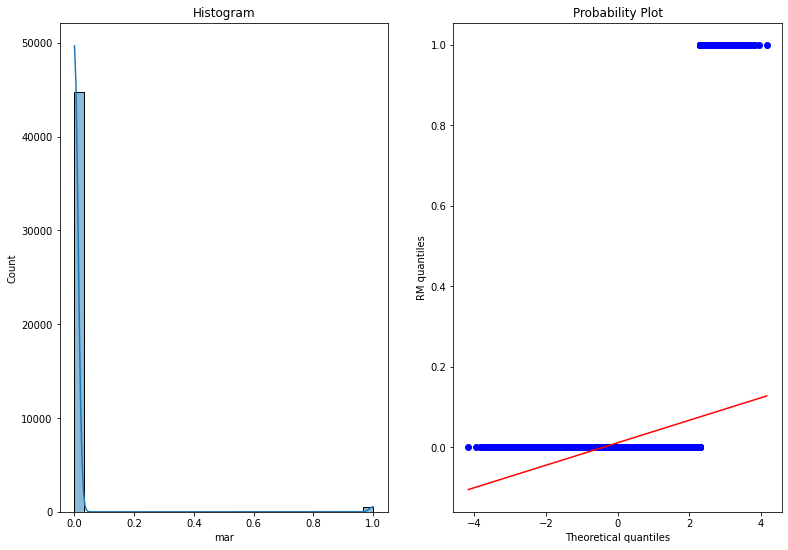

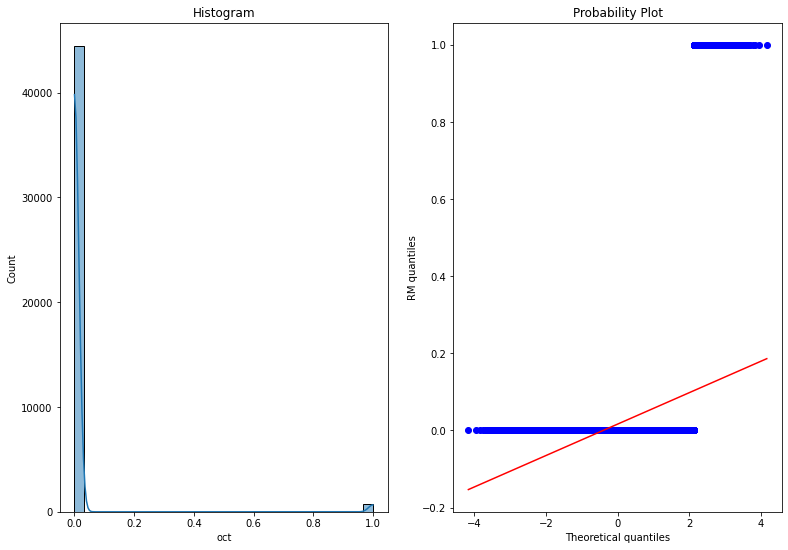

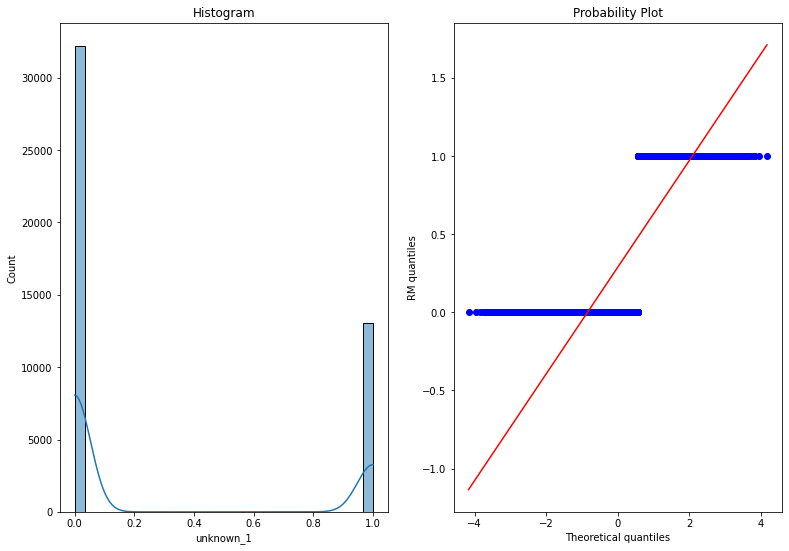

In [42]:
for i in num_columns:
    diagnostic_plots(df1,i)

**Are any model assumptions violated?**

As none of the predictors are on line, all the model assumptions are violated.

<AxesSubplot:>

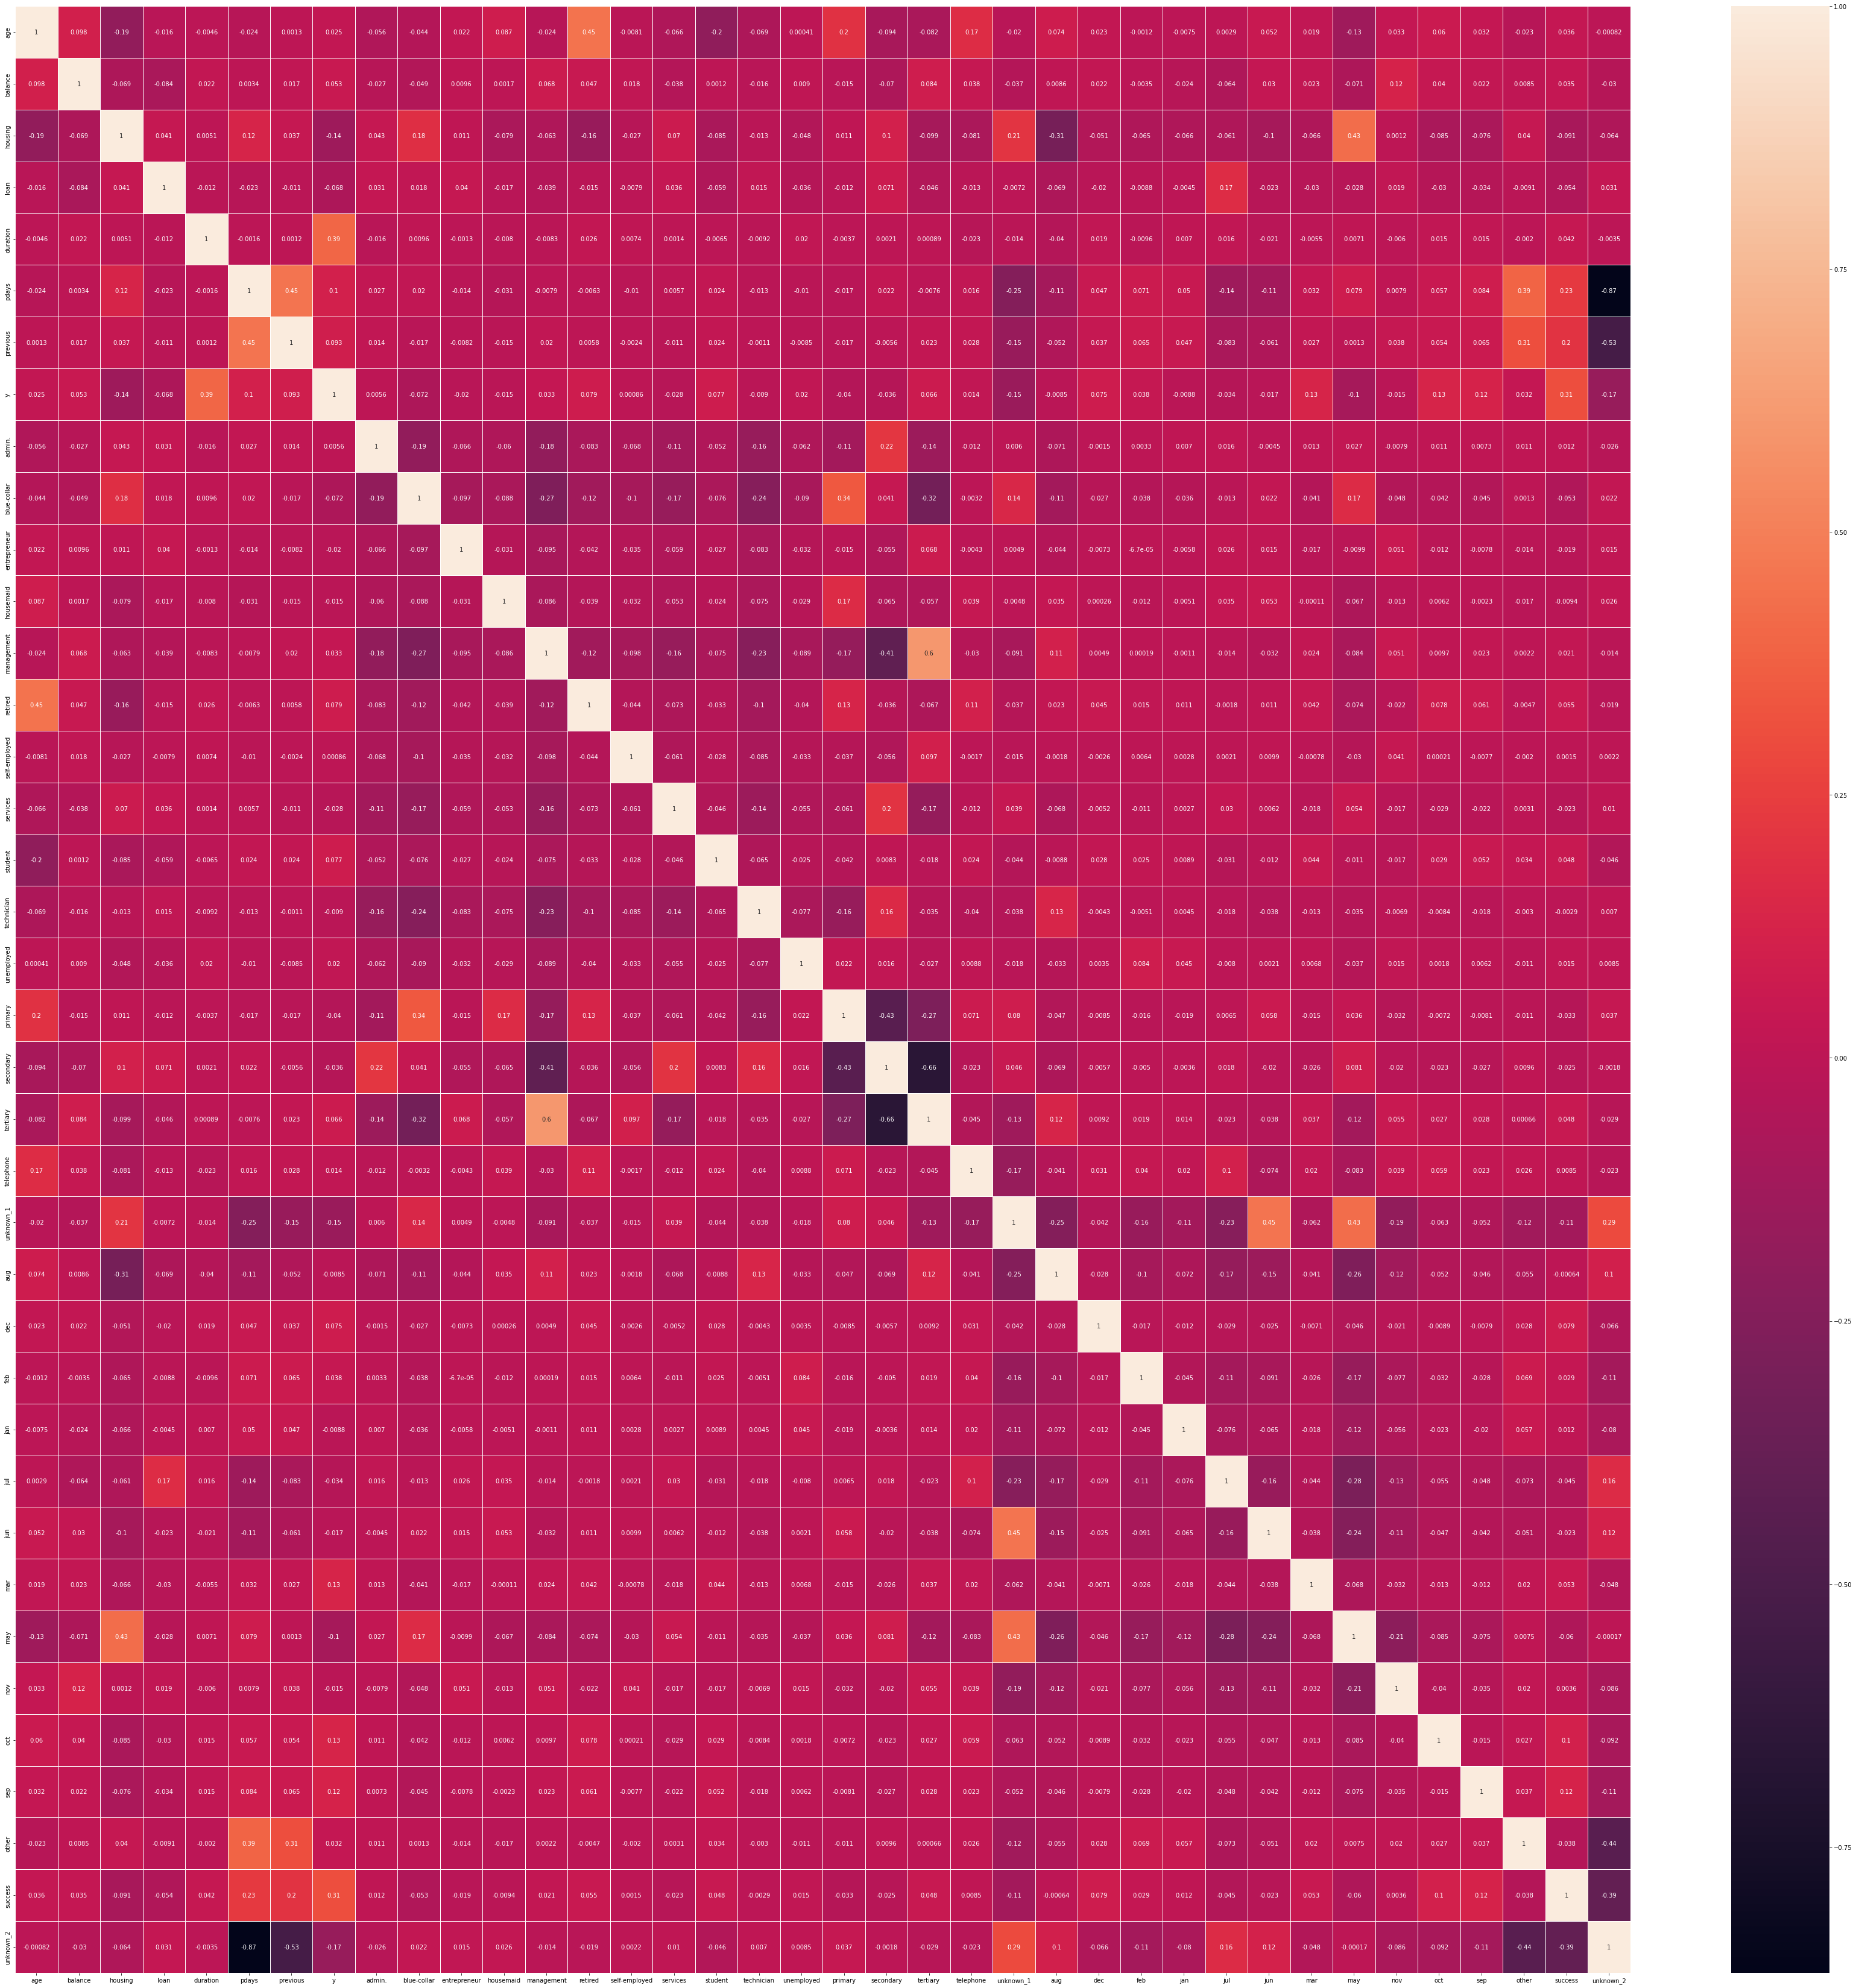

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(60,60))  
sns.heatmap(df1.corr(), annot=True, linewidths=.5, ax=ax)

**Is there any multicollinearity in the model?**

All the variables are correlated to itself only , hence it is not multicolinear.


In [44]:
Columns = df1[['duration', 'pdays', 'housing', 'age', 'unknown_1']]

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = Columns.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(Columns.values, i)
                          for i in range(len(Columns.columns))]
  
print(vif_data)

     feature       VIF
0   duration  1.904448
1      pdays  1.271637
2    housing  2.190047
3        age  2.859270
4  unknown_1  1.580342


**In the multivariate models are predictor variables independent of all the other predictor variables?**
 
None of the variable is having same Variance Inflation Factor(VIF). Hence variables are independent of each other.

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model**

The following are the most significant predictor variables - 
Duration, pdays, housing, age

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
X = df1.drop(['y'], axis=1)
y = df1['y']
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 0, test_size = 0.2)
model = XGBClassifier ( max_dept = 3, subsample = 1, n_estimators = 300, learning_rate = 0.050 )
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_predict = model.predict(X_test)
print('Train accuracy', accuracy_score(y_train, y_train_predict))
print('Test accuracy', accuracy_score(y_test, y_predict))

[19:29:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

Train accuracy 0.9308228268082283
Test accuracy 0.9030189096538759


**Explain how you are preventing overfitting?**

As testing and training data accuracy is close to each other. Hence there is no overfitting in the data. 

**Which hyperparameters are important?**

The following hypterparameters are important (Model = XGBClassifier):

max_dept = 3, subsample = 1, n_estimators = 300, learning_rate = 0.050

**Does the model make sense?**

Yes, It makes sense but it can be improved as the R^2 value is low.

In [48]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
gbm = GradientBoostingClassifier()
mse = cross_val_score(gbm,X,y,scoring= 'neg_mean_squared_error',cv=5)
mean_mse = np.mean(mse)
print(mean_mse)

-0.22468221639964753


In [49]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor = GridSearchCV(ridge,parameters,scoring= 'neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.27001e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.27001e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.27001e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


{'alpha': 100}
-0.0965022644304023


**Does regularization help?**

The RMSE calculated by Ridge is lesser than the RMSE calculated by the AutoML algorithm (0.09 < 0.2156285069896893 (RMSE)). Hence regularization is not needed.

**Which independent variables are significant?**

The following are the independent variables - 

Duration, pdays, housing, age

As there VIF is different.

In [50]:
import scipy.stats as stats

df1['duration_Zscore'] = stats.zscore(df1['duration'])
df1['pdays_Zscore'] = stats.zscore(df1['pdays'])
df1['telephone_Zscore'] = stats.zscore(df1['telephone'])
df1['age_Zscore'] = stats.zscore(df1['age'])
print(df1.head())


z_tdc = df1[['duration_Zscore']].mean()
z_tdm = df1[['pdays_Zscore']].mean()
z_tem = df1[['telephone_Zscore']].mean()
z_csc = df1[['age_Zscore']].mean()
print(round(z_tdc,4))
print(round(z_tdm,4))
print(round(z_tem,4))
print(round(z_csc,4))

   age  balance  housing  loan  duration  pdays  previous  y  admin.  \
0   58     2143        1     0       261     -1         0  0       0   
1   44       29        1     0       151     -1         0  0       0   
2   33        2        1     1        76     -1         0  0       0   
3   47     1506        1     0        92     -1         0  0       0   
4   33        1        0     0       198     -1         0  0       0   

   blue-collar  ...  nov  oct  sep  other  success  unknown_2  \
0            0  ...    0    0    0      0        0          1   
1            0  ...    0    0    0      0        0          1   
2            0  ...    0    0    0      0        0          1   
3            1  ...    0    0    0      0        0          1   
4            0  ...    0    0    0      0        0          1   

   duration_Zscore  pdays_Zscore  telephone_Zscore  age_Zscore  
0         0.011016     -0.411453         -0.262091    1.606965  
1        -0.416127     -0.411453         -0.26

**Is the relationship significant?**

Z_score == 0 it means all the predictors are on regression line it means the relationship is significant.

**Coding professionalism?**


https://www.geeksforgeeks.org/hyperparameter-tuning/

https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/




<AxesSubplot:xlabel='y', ylabel='count'>

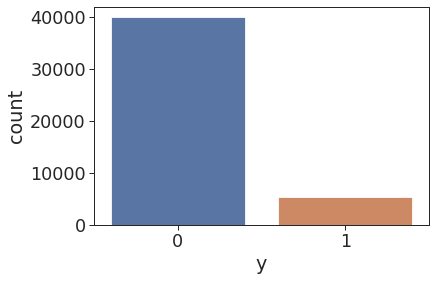

In [51]:
sns.set_context('paper', font_scale = 2) 
sns.set_style('ticks') 
sns.countplot(x ='y', data = df1, palette ='deep') 

**Conclusion -**

There are very less number of people who subscribed for long term deposits. The best model algorithm is 'XGBOOST'. There is no overfitting in the data as the testing data accuracy is close to training data accuracy. The model accuracy can be improved as the R^2 value is less. 

**Did I explain my licensing clearly?** 

MIT License

Copyright (c) 2023 Viral Jangale

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
